# Part I 머신러닝
# chpater 7 앙상블 학습과 랜덤 포레스트

In [1]:
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

* 앙상블 학습 : 일련의 예측기(분류나 회귀모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을수 있을 것이다.

* 앙상블 방법

    훈련세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬수 있다. 예측을 하려면 모든 개별 트리의 예측을 구하면 되고 그런 다음 가장 많은 선택을 받은 클래스를 예측으로 삼는다. 결정트리의 앙상블을 랜덤 포레스트(random forest)라고 한다.

## 7.1 투표 기반 분류기

* 직접 투표(hard voting)

    정확도가 80%인 분류기 여러개를 훈련 시켰다고 가정하자
    
    아마도 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등을 가지고 있을 수있다.
    
    더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측 하는 것이다.

각 분류기는 약한 학습기(weak learner)일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기(strong learner)가 될것이다.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

그림 저장: law_of_large_numbers_plot


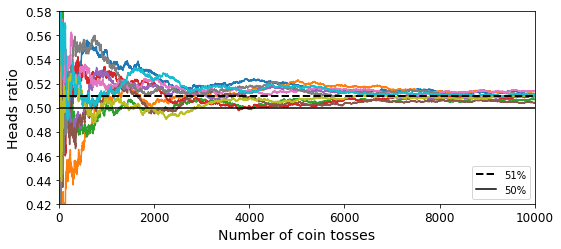

In [3]:
#큰수의 법칙
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

    앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.
    다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것이다.
    이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
#사이킷런의 투표 기반 분류기(VotingClassfier)를 만들고 훈련시키기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
#테스트셋 정확도
from sklearn.metrics import accuracy_score
for clf in(log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.888


투표 기반 분류기가 다른 것들보다 정확도가 높다

* 간접투표(soft voting)

    모든 분류기가 클래스의 확률을 예측할수 있으면, 개별 분류기의 예측을 평균 내어 가장 높은 클래스를 예측할 수 있다.
    
    이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높다.

## 7.2 배깅과 페이스팅

* 배깅(bagging, bootstrap aggregating) : 훈련 세트에 중복을 허용하여 샘플링 하는 방식

* 페이스팅(pasting) : 중복을 허용하지 않고 샘플링 하는 방식

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, n_jobs = -1)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기 처럼 클래스 확률을 추정할 수 있으면 직접투표 대신 간접 투표 방식을 사용한다.

In [8]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


그림 저장: decision_tree_without_and_with_bagging_plot


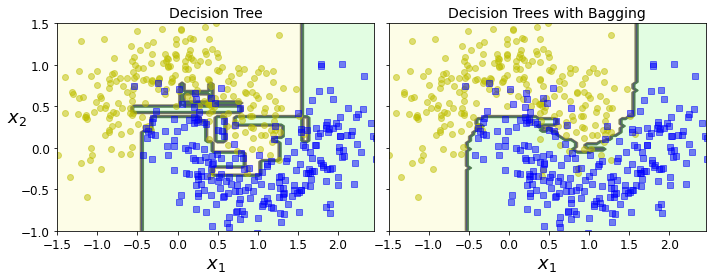

In [10]:
#단일 결정 트리와 5..개 트리로 만든 배깅 앙상블 비교
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

앙상블의 예측(오른쪽)이 결정트리 하나의 예측보다 훨씬 일반화가 잘되었다.

앙상블은 비슷한 편향에서 더 작은 분산을 만든다.(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다.)

In [11]:
#oob 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [12]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [13]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 7.3 랜덤 패치와 랜덤 서브스페이스

특성 샘플링

예측기는 무작위로 선택한 입력 특성의 일부분으로 후련

이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용

* 랜덤 패치 방식(random patches method) : 훈련 특성과 샘플을 모두 샘플링 하는것

* 랜덤 서브스페이스 방식(random subspace method) : 훈련 샘플을 모두 사용하고 특성은 샘플링 하는것

특성 샘플링은 더 다양한 예측기를 만들며 평향을 늘리는 대신 분산을 낮춘다

## 7.4 랜덤 포레스트

* 랜덤 포레스트 : 일번작으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블 입니다.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [19]:
y_pred_rf

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

    램덤 포레스트의 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위석을 더 주입합니다.
    트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 더 낮추어 훌륭한 모델을 만들게 된다.

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators = 500)

In [20]:
bag_clf

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt',
                                                        max_leaf_nodes=16),
                  n_estimators=500)

* 익스트림 랜덤 트리(extremely randomized tree)

    트리를 더욱 무작위로 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택
    
    극단적으로 무작위한 트리의 랜덤 포레스트

    편향 늘고 분산 낮춤, 일반적인 랜덤 포레스트 보다 엑스트라 트리가 훨씬 빠른
    
    

* 특성 중요도

    사이킷런은 어떤 특성을 사용한 노드가 평균적으로 분수도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정
    
    가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.
    
    사이킷런은 훈련이 끝난뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체합이 1이 되도록 결과값을 정규화함

In [21]:
from sklearn.datasets import load_iris
iris= load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09239101698025956
sepal width (cm) 0.02189348299564331
petal length (cm) 0.43476622167008644
petal width (cm) 0.45094927835401055


In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [24]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


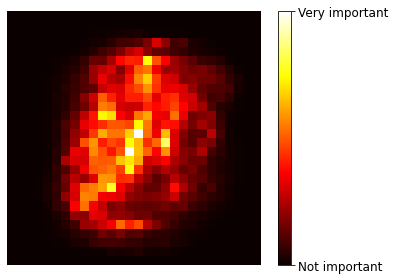

In [25]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

랜덤 포레스트 분류기에서 얻는 MNIST 픽셀 중요도

## 7.5 부스팅

* 부스팅(boosting)

    약한 학습기를 여러개 연결하여 학습기를 만드는 앙상블 방법
    
    아이디어 : 모델을 보완해 나가면서 일련의 예측기를 학습시키는 것

* 에이다 부스트

    이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것
    
    새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.
    
    

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

그림 저장: boosting_plot


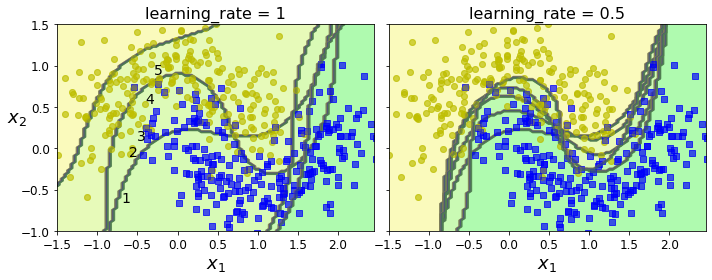

In [27]:
# 연속된 예측기의 결정 경계
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

연속된 학습 기법에는 중요한 단점이 하나 있다. 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습 될 수 있기 때문에 병렬화(또는 분할)를 할수 없다. 결국 배깅이나 페이스팅만큼 확장성이 높지않다.

In [28]:
#200개의 아주 얇은 결정트리를 기반으로 하는 에이다부스트 분류기를 훈련시키기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm="SAMME.R", learning_rate = 0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

* 그레이디언트 부스팅(gradient boosting)
    
    에이다 부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
    
    에이다 부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여오차(residual error)에 새로운 예측기를 학습시킨다.

In [34]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [36]:
#첫번째 예측기에 생긴 잔여 오차에 두번째 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [37]:
#두번째 예측기에 생긴 잔여 오차에 세번째 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [38]:
X_new = np.array([[0.8]])

In [39]:
#모든 트리의 예측 더하기
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [40]:
y_pred

array([0.52856846])

그림 저장: gradient_boosting_plot


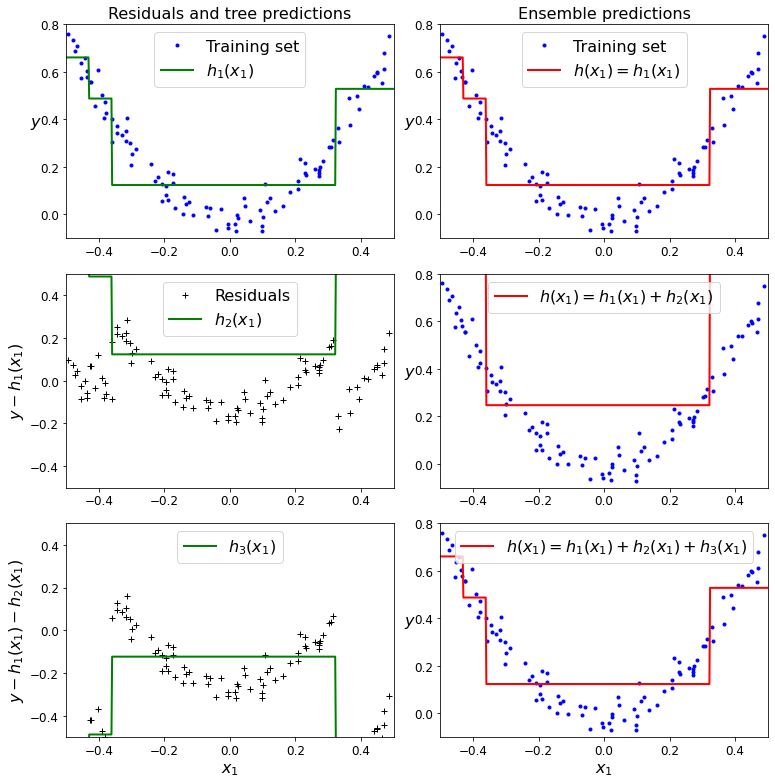

In [41]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

이 그레이디언트 부스팅 그래프에서 첫번째 예측기(왼쪽 위)가 평소와 같이 훈련된다.

그다음 연이은 예측기(왼쪽 중간, 왼쪽 아래) 가 이전의 예측기의 잔여 오차에 훈련된다.

오른쪽 열은 만들어진 앙상블의 예측을 보여준다.

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [43]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

그림 저장: gbrt_learning_rate_plot


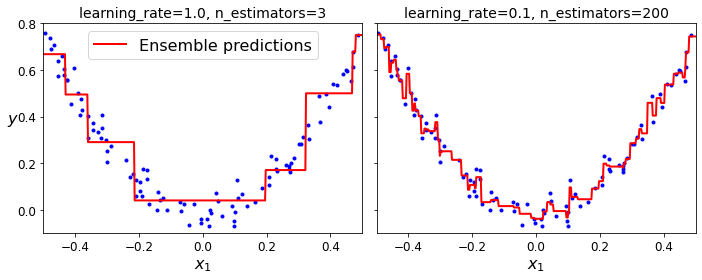

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

예측기가 부족한 경우(왼쪽, 훈련세트를 학습하기에는 트리가 충분 X)과 너무 많은 경우(오른쪽, 트리가 너무 많아 훈련 세트에 과대 적합)의 GBRT 앙상블

* 조기종료
    
    최적의 트리 수를 찾기 위해서는 조기종료 기법을 사용할 수 있다.

    훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator)를 반환한다.
    
    

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

그림 저장: early_stopping_gbrt_plot


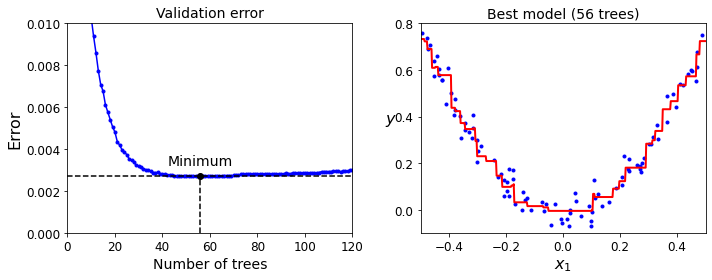

In [47]:
#조기 종료를 사용하여 트리 수 튜닝
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

왼쪽 : 검증 오차

오른쪽 : 최적 모델의 예측

In [48]:
#조기 종료 구현
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
            

In [49]:
print(gbrt.n_estimators)

61


In [50]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


* 확률적 그레이디언트 부스팅(stochastic gradient boosting)

    각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정하여 학습
    
    편향이 높아지는 대신 분산이 낮아 지게됨
    
    훈련속도 UP

* XGBoost(익스트림 그레이디언트 부스팅, extreme gradeint boosting)

    목표 : 매우 빠른 속도, 확장성, 이식성
    
    머신러닝 경연 대회에서 우승 후보들이 사용하는 중요 도구 중 하나

In [52]:
pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [53]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [54]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [55]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

Validation MSE: 0.004000408205406276


In [56]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


C:\Annaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [57]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

24.8 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

19.6 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 7.6 스태킹

* 스태킹(stacking, stacked generlization)

    앙상블에 속한 모든 예측기의 예측을 취합하는 간단함 함수(직접 투표 같은)를 사용하는 대신 취합하는 모델을 훈련시킬수는 없을까?라는 아이디어로 부터 나옴
    
    

## 7.7 연습문제

1. 정확히 같은 훈련 데이터로 다섯 개의 다른 모델을 훈련시켜서 모두 95% 정확도를 얻었다면 이 모델들을 연결하여 더 좋은 결과를 얻을 수 있을까요? 가능하다면 어떻게 해야 할까 요? 그렇지 않다면 왜일까요?

    다섯개의 모델을 훈련시켰고 모두 95%의 정확도를 달성했다면 이들을 연결하여 투표 앙상블(voting ensemble)을 만들어 더 나은 결과를 기대 할 수있다.
    만약 모델이 서로 다르다면(예를 들면 SVM분류기, 결정트리 분류기, 로지스틱 회귀 분류기 등) 훨씬 좋다.
    만약 다른 훈련 샘플에서 훈련되었다면 더더욱 좋다.(이것이 배깅과 페이스팅 앙상블의 핵심)
    하지만 그렇지 않더라고 모델이 서로 많이 다르면 여전히 좋은 결과를 낸다.

2. 직접 투표와 간접 투표 분류기 사이의 차이점은 무엇일까요?

    직접 투표 분류기는 앙상블에 있는 각 분류기의 선택을 분류기의 선택을 카운트해서 가장 많은 투표를 얻는 클래스를 선택한다.
    간접 투표 분류기는 각 클래스의 평균적인 확률 추정값을 계산해서 가장 높은 확률을 가진 클래스를 고른다.
    이 방식은 신뢰가 높은 투표에 더 가중치를 주고 종종 더 나은 성늘을 낸다.
    하지만 앙상블에 있는 모든 분류기가 클래스 확률을 추정할 수 있어야 사용할 수 있다.(예를 들어 사이킷런의 SVM 분류기는 probability = True 로 지정해야 한다.)

3. 배깅 앙상블의 훈련을 여러 대의 서버에 분산시켜 속도를 높일 수 있을까요? 페이스팅 앙상블, 부스팅 앙상블, 랜덤 포레스트, 스태킹 앙상블의 경우는 어떨까요?

    배깅 앙상블의 각 예측기는 독립적이므로 여러 대의 서버에 분산하여 앙상블의 훈련 속도를 높일 수 있다.
    페이스팅 앙상블과 랜덤 포레스트도 같은 이유로 동일하다.
    그러나 부스팅 앙상블의 예측기는 이전 예측기를 기반으로 만들어지므로 훈련이 순차적이어야하고 여러 대의 서버에 분산해서 얻을 수있는 이득이 없다.
    스태킹 앙상블의 경우 한 층의 모든 예측기가 각각 독립적이므로 여러대의 서버에서 병렬로 훈련 될 수 있다.
    그러나 한 층에 있는 예측기들은 이전 층의 예측기들이 훈련된 후에 훈련 될 수 있다.

4. oob 평가의 장점은 무엇인가요?

    oob 평가를 사용하면 배깅 앙상블의 각 예측기가 훈련에 포함되지 않은(즉, 따로 떼어놓은) 샘플을 사용해 평가된다.
    이는 추가적인 검증 세트가 없어도 편향되지 않게 앙상블을 평가하도록 도와준다.
    그러므로 훈련에 더 많은 샘플을 사용할 수 있어서 앙상블의 성능은 조금 더 향상될 것이다.

5. 무엇이 엑스트라 트리를 일반 랜덤 포레스트보다 더 무작위하게 만드나요? 추가적인 무작 위성이 어떻게 도움이 될까요? 엑스트라 트리는 일반 랜덤 포레스트보다 느릴까요, 빠를 까요?

    랜덤 포레스트에서 트리가 성장할 때 각 노드에서 특성의 일부를 무작위로 선택해 분할에 사용한다.
    엑스트라 트리에서도 이는 마찬가지지만 한 단계 더 나아가서 일반 결정 트리처럼 가능한 최선의 임계점을 찾는 것이 아니라 각 특성에 대해 랜덤한 임계점을 사용한다.
    이 추가적인 무작위성은 규제처럼 작동한다.
    즉, 랜덤 포레스트가 훈련 데이터에 과대 적합되었다면 엑스트라 트리는 그렇지 않을 것이다.
    또한 엑스트라 트리는 가능한 최선의 임계점을 찾지 않기 때문에 랜덤 포레스트보다훨씬 빠르게 훈련된다.
    그러나 예측을 할 때는 랜덤 포레스트보다 더 빠르지도 느리지도 않다.

6. 에이다부스트 앙상블이 훈련 데이터에 과소적합되었다면 어떤 매개변수를 어떻게 바꾸어야 할까요?

    에이다부스트 앙상블이 훈련 데이터에 과소적합되었다면 예측기 수를 증가시키거나 기반 예측기의 규제 하이퍼파라미터를 감소시켜 볼 수 있다.
    또한 학습률을 약간 증가 시켜 볼 수 있다.

7. 그레이디언트 부스팅 앙상블이 훈련 데이터에 과대적합되었다면 학습률을 높여야 할까요, 낮춰야 할까요?

    그레이디언트 부스팅 앙상블이 훈련 세트에 과대적합되었다면 학습률을 감소 시켜야한다.
    (예측기 수가 너무 많으면) 알맞은 개수를 찾기 위해 조기 종료 기법을 사용할 수 있다.

8. (3장에서 소개한) MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕 니다(예를 들면 훈련에 50,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플). 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킵니다. 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결해보세요. 앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
# 훈련세트, 검증세트, 테스트 세트로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [61]:
#랜덤 포레스트 분류기, 엑스트라 분류기, SVM 같은 여러 종류의 분류기 훈련
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [62]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [63]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [65]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9606]

SVM이 다른 분류기보다 성능이 떨어지긴 하지만 투표 기반 분류기의 성능을 향상 시킬 수도 있으므로 그대로 둔다

In [66]:
# 간접 또는 직접 분류기를 사용하는 앙상블로 연결
from sklearn.ensemble import VotingClassifier

In [67]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [68]:
voting_clf = VotingClassifier(named_estimators)

In [70]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [71]:
voting_clf.score(X_val, y_val)

0.97

In [72]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9606]

SVM모델을 제거해서 성능이 향상되는지 확인 해보기

In [73]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [74]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [75]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [76]:
del voting_clf.estimators_[2]

In [77]:
voting_clf.score(X_val, y_val)

0.9737

값이 좋아진것을 보니 SVM모델이 성능을 저하 시키고 있었음

In [78]:
#간접 투표 분류기 사용
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)

0.97

직접 투표 방식이 좋음

In [79]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9711

In [80]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9586]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킨다

9. 이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요. 축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다! 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?


In [81]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [82]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [83]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [84]:
rnd_forest_blender.oob_score_

0.9708

In [85]:
#테스트 세트에 앙상블 평가하기
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [86]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [87]:
from sklearn.metrics import accuracy_score

In [88]:
accuracy_score(y_test, y_pred)

0.9701

투표 기반 분류기보다 성능 낮다

최선의 개별 분류기만큼 뛰어나지는 않다.